In [1]:
!pip3 install torch torchvision torchaudio > NULL
!pip install captum > NULL

In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from captum.attr import IntegratedGradients
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


torch.manual_seed(42)

Defining device

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

Connecting to device

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading data

In [5]:
data_X = np.load('./drive/MyDrive/proj/data_norm_X.npy')
data_Y = np.load('./drive/MyDrive/proj/data_norm_Y.npy')

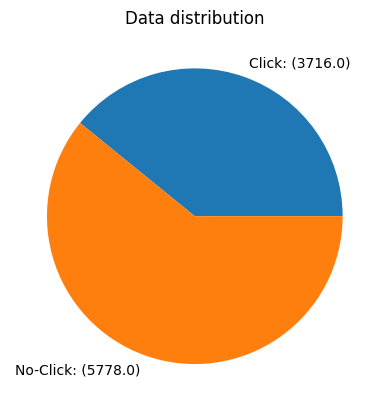

In [6]:
plt.title('Data distribution')
plt.pie(np.array([sum(data_Y), len(data_Y)-sum(data_Y)]), labels=[f'Click: ({sum(data_Y)})', f'No-Click: ({len(data_Y)-sum(data_Y)})'])
plt.show()

Dimensionality reduction

In [360]:
# pca = PCA(n_components=len(data_X[0])//8)
# pca.fit(data_X)
# data_X = pca.transform(data_X)

PCA(n_components=379)

Splitting data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [8]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((7595, 3036), (950, 3036), (949, 3036), (7595,), (950,), (949,))

Some necessary functions

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [110]:
def loss_fn(preds, labels):
    eps = torch.tensor([1e-8]).to(DEVICE)
    loss = -torch.mean(torch.log(torch.max(torch.gather(preds, dim=1, index=labels[..., None].to(int)), eps)))
    return loss

class Model(torch.nn.Module):

    def __init__(self, input_size=3036):
        super(Model, self).__init__()

        self.linear1 = torch.nn.Linear(input_size, input_size//2)
        self.linear2 = torch.nn.Linear(input_size//2, input_size//4)
        self.linear3 = torch.nn.Linear(input_size//4, input_size//8)
        self.linear4 = torch.nn.Linear(input_size//8, 2)
        self.activation = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=-1)
        self.batch_norm1 = torch.nn.BatchNorm1d(input_size//2)
        self.batch_norm2 = torch.nn.BatchNorm1d(input_size//4)
        self.batch_norm3 = torch.nn.BatchNorm1d(input_size//8)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.softmax(x)

        return x

In [111]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for batch in tqdm(data_loader, position=0, leave=True):
        X_batch = batch[0].to(DEVICE)
        y_batch = batch[1].to(DEVICE)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    return running_loss / len(data_loader)

def validate(model, data_loader, criterion):
  model.eval()
  running_loss = 0.0

  with torch.no_grad():
      for batch in tqdm(data_loader, position=0, leave=True):
          X_batch = batch[0].to(DEVICE)
          y_batch = batch[1].to(DEVICE)
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)
          running_loss += loss.item()

  return running_loss / len(data_loader)

Defining hyperparameters

In [125]:
model = Model(input_size=X_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=8e-4)
loss_fn = loss_fn
batch_size = 32
num_epochs = 30
val_min_loss = float("+inf")
history = []

model_name = ""

while model_name == "":
    model_name = input("Input proper model name:\t")

Input proper model name:	test


Defining data loader

In [126]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training

In [127]:
for epoch in range(num_epochs):
    mean_train_loss = train(model, train_dataloader, loss_fn, optimizer)
    mean_val_loss = validate(model, val_dataloader, loss_fn)

    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
        f"\nBest Val loss: {round(val_min_loss, 4)}"
    )

    if mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        print("Saving best model....")
        torch.save(model.state_dict(), f"./drive/MyDrive/proj/{model_name}_best.pt")
torch.save(model.state_dict(), f"./drive/MyDrive/proj/{model_name}_last.pt")

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30]
Train Loss: 0.4904
Val Loss: 0.4177
Best Val loss: inf
Saving best model....


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2/30]
Train Loss: 0.4466
Val Loss: 0.4216
Best Val loss: 0.4177


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3/30]
Train Loss: 0.4335
Val Loss: 0.4063
Best Val loss: 0.4177
Saving best model....


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4/30]
Train Loss: 0.4239
Val Loss: 0.4288
Best Val loss: 0.4063


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5/30]
Train Loss: 0.4246
Val Loss: 0.4227
Best Val loss: 0.4063


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6/30]
Train Loss: 0.4232
Val Loss: 0.4236
Best Val loss: 0.4063


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7/30]
Train Loss: 0.4215
Val Loss: 0.4058
Best Val loss: 0.4063
Saving best model....


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8/30]
Train Loss: 0.4194
Val Loss: 0.4208
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9/30]
Train Loss: 0.4156
Val Loss: 0.4142
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10/30]
Train Loss: 0.41
Val Loss: 0.4252
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [11/30]
Train Loss: 0.418
Val Loss: 0.4161
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [12/30]
Train Loss: 0.4127
Val Loss: 0.4236
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [13/30]
Train Loss: 0.4093
Val Loss: 0.4132
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [14/30]
Train Loss: 0.41
Val Loss: 0.411
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [15/30]
Train Loss: 0.4114
Val Loss: 0.4101
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [16/30]
Train Loss: 0.409
Val Loss: 0.421
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [17/30]
Train Loss: 0.4047
Val Loss: 0.4234
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [18/30]
Train Loss: 0.4076
Val Loss: 0.4174
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [19/30]
Train Loss: 0.3996
Val Loss: 0.4222
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [20/30]
Train Loss: 0.4034
Val Loss: 0.4074
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [21/30]
Train Loss: 0.4031
Val Loss: 0.4101
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [22/30]
Train Loss: 0.3989
Val Loss: 0.4097
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [23/30]
Train Loss: 0.3988
Val Loss: 0.4105
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [24/30]
Train Loss: 0.3971
Val Loss: 0.4146
Best Val loss: 0.4058


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [25/30]
Train Loss: 0.3975
Val Loss: 0.4037
Best Val loss: 0.4058
Saving best model....


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [26/30]
Train Loss: 0.3945
Val Loss: 0.4214
Best Val loss: 0.4037


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [27/30]
Train Loss: 0.3908
Val Loss: 0.4263
Best Val loss: 0.4037


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [28/30]
Train Loss: 0.3869
Val Loss: 0.4269
Best Val loss: 0.4037


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [29/30]
Train Loss: 0.3906
Val Loss: 0.4261
Best Val loss: 0.4037


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [30/30]
Train Loss: 0.3859
Val Loss: 0.424
Best Val loss: 0.4037


Train-Val Loss

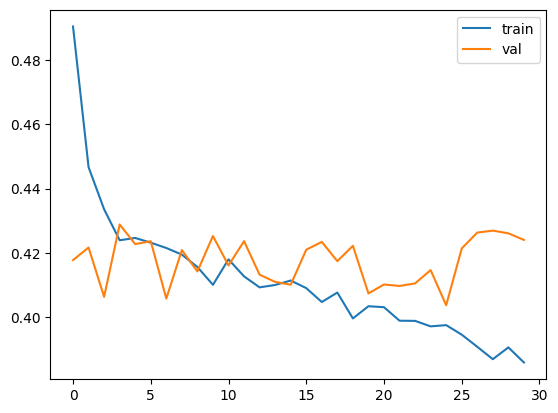

In [128]:
plt.plot(history)
plt.legend(["train", "val"])

Accuracy and metrics

In [129]:
def calc_acc(pred, label):
    pred = np.argmax(pred, axis=-1)
    return f'{(np.sum(pred == label)/len(pred) * 100).round(3)}%'

Precision = 72.414%
Recall = 82.895%
ACC = 80.526%


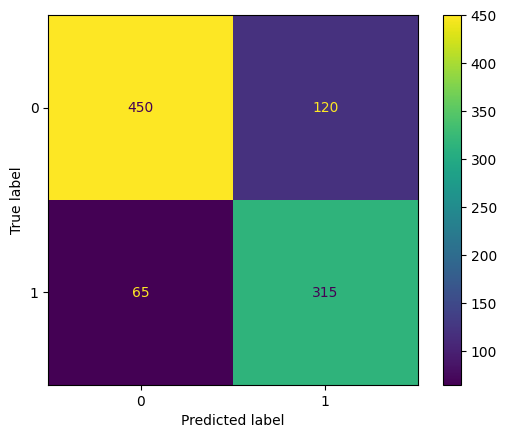

In [131]:
model.load_state_dict(torch.load(f"./drive/MyDrive/proj/{model_name}_best.pt"))
model.to(DEVICE)
model.eval()

pred = model(torch.from_numpy(X_test).to(torch.float32).to(DEVICE)).detach().cpu().numpy()

conf_matrix = confusion_matrix(y_test, np.argmax(pred, axis=-1))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

# Step 2: Calculate Precision
precision = precision_score(y_test, np.argmax(pred, axis=-1))
print(f"Precision = {(precision * 100).round(3)}%")

# Step 3: Calculate Recall
recall = recall_score(y_test, np.argmax(pred, axis=-1))
print(f"Recall = {(recall * 100).round(3)}%")
print(f'ACC = {calc_acc(pred, y_test)}')

plt.show()


Explainable AI

In [135]:
explainer = IntegratedGradients(model.double())

attributions, delta = explainer.attribute(torch.from_numpy(X_test[:200]).to(DEVICE),
                                          target=1,
                                          return_convergence_delta=True,
                                           n_steps=1_000)

attributions = attributions[0].squeeze().cpu().detach().numpy()

In [136]:
attributions_sum = [attributions[0], attributions[1], attributions[2], attributions[3], attributions[4],
                    attributions[5:15].sum(), attributions[15:1494].sum(), attributions[1494:1500].sum(), attributions[1500:].sum()]

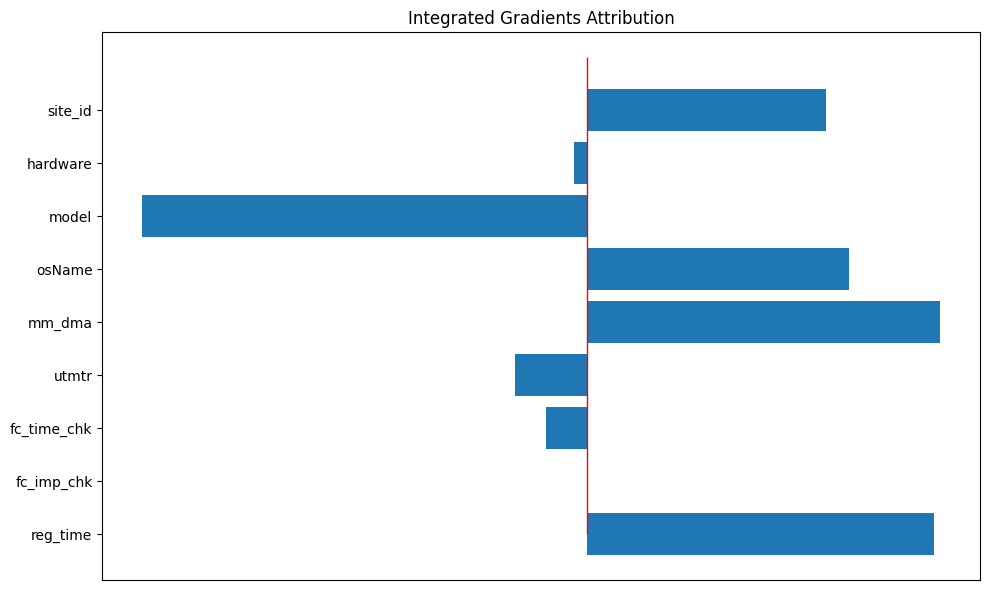

In [137]:
columns = ['reg_time',
           'fc_imp_chk',
           'fc_time_chk',
           'utmtr',
           'mm_dma',
           'osName',
           'model',
           'hardware',
           'site_id']

fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax.barh(range(9), attributions_sum)
ax.set_title('Integrated Gradients Attribution')
ax.set_xticks([])
ax.set_yticks(range(9))
ax.set_yticklabels(columns, rotation=0, fontsize=10)
ax.vlines(0, 0, 9, linestyles ="solid", colors ="r",linewidth=1)
plt.tight_layout()

plt.show()
